# TF-IDF

TF-IDF tells you: "How important is a word in this document, compared to how common it is across all documents?"

It turns text into numbers (vectors) based on word usage patterns.

TF (Term Frequency): How often a word appears in this one text

IDF (Inverse Document Frequency): How rare the word is across all texts

# Why TF-IDF is good for detecting lazy humanizers

Note: lazy humanizers are the one barely paraphrasing, using the same words and swap places, add spelling miskakes and capitalization.

- Using same words -> same word frequencies -> similar TF
- adds filler -> has very low IDF -> adds almost no vector change

# Use TF-IDF Vectorization (Optional: with n-gram)

In [1]:
import pandas as pd

In [2]:
# set pandas to display every column
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('../datasets.csv')

# Preprocessing
lowercase, cleaning, tokenization, stopwords, and stemming

In [5]:
import multiprocessing as mp
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/warittee/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
def preprocess_text(text):
    lowercased = text.lower()
    remove_punctuation = re.sub(r'[^\w\s]', '', lowercased)
    remove_whitespace = remove_punctuation.strip()
    #tokenization
    tokenized_text = word_tokenize(remove_whitespace)
    #remove stop words
    stopwords_list = set(stopwords.words('english'))
    stopwords_removed = [word for word in tokenized_text if word not in stopwords_list]

    #stemming 
    ps = PorterStemmer()
    stemmed_text = [ps.stem(word) for word in stopwords_removed]
    df = pd.DataFrame({
        'Document': [text],
        'Lowercase': [lowercased],
        'Cleaning': [remove_whitespace],
        'Tokenization': [tokenized_text],
        'Stopwords': [stopwords_removed],
        'Stemming': [stemmed_text]
    })
    
    return df

In [7]:
def preprocess(df, column_name):
    preprocessed_df = pd.DataFrame()
    for text in df[column_name]:
        preprocessed_text = preprocess_text(text)
        preprocessed_df = pd.concat([preprocessed_df, preprocessed_text], ignore_index=True)
    return preprocessed_df
preprocessed_ai_essays = preprocess(df, 'AI_essay')
preprocessed_humanized_essays = preprocess(df, 'humanized_essay')

In [8]:
corpus = pd.concat([preprocessed_ai_essays, preprocessed_humanized_essays], ignore_index=True)
corpus['type'] = ['AI_essay'] * len(preprocessed_ai_essays) + [df.loc[i, 'humanizer'] for i in range(len(preprocessed_humanized_essays))]
corpus.head()

,Document,Lowercase,Cleaning,Tokenization,Stopwords,Stemming,type
0,The integration of social media into the lives...,the integration of social media into the lives...,the integration of social media into the lives...,"[the, integration, of, social, media, into, th...","[integration, social, media, lives, young, peo...","[integr, social, media, live, young, peopl, ne...",AI_essay
1,The integration of social media into the lives...,the integration of social media into the lives...,the integration of social media into the lives...,"[the, integration, of, social, media, into, th...","[integration, social, media, lives, young, peo...","[integr, social, media, live, young, peopl, ne...",AI_essay
2,The integration of social media into the lives...,the integration of social media into the lives...,the integration of social media into the lives...,"[the, integration, of, social, media, into, th...","[integration, social, media, lives, young, peo...","[integr, social, media, live, young, peopl, ne...",AI_essay
3,The integration of social media into the lives...,the integration of social media into the lives...,the integration of social media into the lives...,"[the, integration, of, social, media, into, th...","[integration, social, media, lives, young, peo...","[integr, social, media, live, young, peopl, ne...",AI_essay
4,The integration of social media into the lives...,the integration of social media into the lives...,the integration of social media into the lives...,"[the, integration, of, social, media, into, th...","[integration, social, media, lives, young, peo...","[integr, social, media, live, young, peopl, ne...",AI_essay


In [9]:
corpus.tail()

,Document,Lowercase,Cleaning,Tokenization,Stopwords,Stemming,type
355,Childhood is frequently recalled as a period m...,childhood is frequently recalled as a period m...,childhood is frequently recalled as a period m...,"[childhood, is, frequently, recalled, as, a, p...","[childhood, frequently, recalled, period, mark...","[childhood, frequent, recal, period, mark, sim...",Grammarly
356,Childhood is often remembered as a realm of si...,childhood is often remembered as a realm of si...,childhood is often remembered as a realm of si...,"[childhood, is, often, remembered, as, a, real...","[childhood, often, remembered, realm, simplici...","[childhood, often, rememb, realm, simplic, ima...",HumanizeAI
357,Childhood is frequently viewed through the pri...,childhood is frequently viewed through the pri...,childhood is frequently viewed through the pri...,"[childhood, is, frequently, viewed, through, t...","[childhood, frequently, viewed, prisms, imagin...","[childhood, frequent, view, prism, imagin, sim...",Quillbot
358,People tend to recall their childhood through ...,people tend to recall their childhood through ...,people tend to recall their childhood through ...,"[people, tend, to, recall, their, childhood, t...","[people, tend, recall, childhood, simple, memo...","[peopl, tend, recal, childhood, simpl, memori,...",UndetectableAI
359,Childhood is remembered as a time of simplicit...,childhood is remembered as a time of simplicit...,childhood is remembered as a time of simplicit...,"[childhood, is, remembered, as, a, time, of, s...","[childhood, remembered, time, simplicity, imag...","[childhood, rememb, time, simplic, imagin, tim...",writehuman.ai


# Calculate TF-IDF vector

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
def calculate_tfidf(corpus, ngram_range):
    stemming = corpus['Stemming'].apply(' '.join)

    #Count TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    tfidf_matrix = vectorizer.fit_transform(stemming)

    #Get words from stopwords to use as headers
    feature_names = vectorizer.get_feature_names_out()

    df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    df_tfidf = pd.concat([corpus.reset_index(drop=True), df_tfidf.reset_index(drop=True)], axis=1)

    return df_tfidf

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
def calculate_cosine_similarity(df_tfidf, row1, row2):
    vector1 = df_tfidf.iloc[row1, 7:].values.reshape(1,-1)
    vector2 = df_tfidf.iloc[row2, 7:].values.reshape(1,-1)

    cosim = cosine_similarity(vector1, vector2)
    return cosim[0][0]

# Ngram = (1,1)

In [12]:
df_tfidf = calculate_tfidf(corpus, (1,1))
df_1_1 = df.copy()
for i, row in df.iterrows():
    cosim = calculate_cosine_similarity(df_tfidf, i, i+180)
    df_1_1.loc[i, 'TF-IDF_cosim'] = cosim
df_1_1

,topic,length,AI_model,humanizer,AI_essay,humanized_essay,TF-IDF_cosim
0,1,1,gemini2.5pro,AIHumanizer,The integration of social media into the lives...,The way social media has woven itself into the...,0.359997
1,1,1,gemini2.5pro,Grammarly,The integration of social media into the lives...,Social media has become a big part of young pe...,0.336786
2,1,1,gemini2.5pro,HumanizeAI,The integration of social media into the lives...,The penetration of social media into the lives...,0.502740
3,1,1,gemini2.5pro,Quillbot,The integration of social media into the lives...,Social media's introduction into young people'...,0.505379
4,1,1,gemini2.5pro,UndetectableAI,The integration of social media into the lives...,Young people face a harmful environment throug...,0.428381
...,...,...,...,...,...,...,...
175,5,3,gpt4.0,Grammarly,Childhood is often remembered through the lens...,Childhood is frequently recalled as a period m...,0.710457
176,5,3,gpt4.0,HumanizeAI,Childhood is often remembered through the lens...,Childhood is often remembered as a realm of si...,0.672900
177,5,3,gpt4.0,Quillbot,Childhood is often remembered through the lens...,Childhood is frequently viewed through the pri...,0.689754
178,5,3,gpt4.0,UndetectableAI,Childhood is often remembered through the lens...,People tend to recall their childhood through ...,0.601803


In [13]:
# get some statistics of the cosine similarity (max, min, mean, median, quartiles)
df_1_1.describe()['TF-IDF_cosim']

count    180.000000
mean       0.643395
std        0.119979
min        0.137100
25%        0.566428
50%        0.659692
75%        0.725119
max        0.971951
Name: TF-IDF_cosim, dtype: float64

In [14]:
# for each humanizer, get the average of the cosine similarity (except index 161 since it is an outlier)
df_1_1_cleaned = df_1_1.drop(index=161)
df_1_1_cleaned.reset_index(inplace=True, drop=True)
df_1_1_humanizer_length = df_1_1_cleaned.groupby(['humanizer', 'length'])['TF-IDF_cosim'].mean().reset_index()
#map length from '1' to 'short', '2' to 'medium', '3' to 'long'
df_1_1_humanizer_length['length'] = df_1_1_humanizer_length['length'].map({1: 'short', 2: 'medium', 3: 'long'})

In [15]:
df_1_1_cleaned = df_1_1.drop(index=161)
df_1_1_cleaned.reset_index(inplace=True, drop=True)
df_1_1_humanizer = df_1_1_cleaned.groupby('humanizer')['TF-IDF_cosim'].mean().reset_index()
df_1_1_humanizer = df_1_1_humanizer.sort_values(by='TF-IDF_cosim')
df_1_1_humanizer

,humanizer,TF-IDF_cosim
4,UndetectableAI,0.593840
5,writehuman.ai,0.644740
2,HumanizeAI,0.648192
1,Grammarly,0.657888
0,AIHumanizer,0.662138
3,Quillbot,0.670495


# Visualization

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns

In [19]:
custom_palette = sns.color_palette(['#B08A4C', '#675200', '#250000'])
sns.set_palette(custom_palette)

/var/folders/sl/36wj2dpn1fvgpr5ydrsxz8wm0000gn/T/ipykernel_26939/500340972.py:18: UserWarning: Mismatched number of handles and labels: len(handles) = 5 len(labels) = 4
  ax.legend(handles=handles, labels=labels, title='Essay Length / Mean', bbox_to_anchor=(1, 1), loc='upper left')


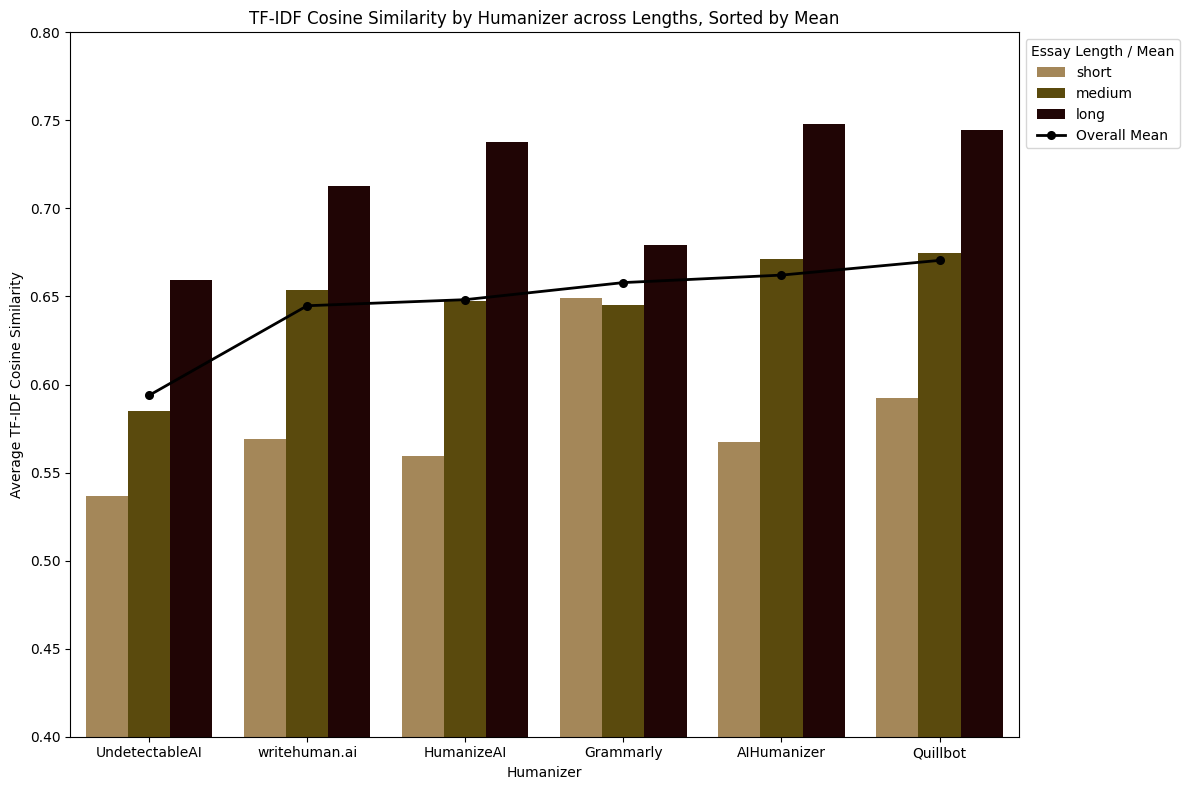

In [20]:
sorted_humanizer_order = df_1_1_humanizer['humanizer'].tolist()

from matplotlib.lines import Line2D
plt.figure(figsize=(12,8))
#bar plot
ax = sns.barplot(data=df_1_1_humanizer_length, x='humanizer', y='TF-IDF_cosim', hue='length', order=sorted_humanizer_order)

#line plot of mean
sns.pointplot(data=df_1_1_humanizer, x='humanizer', y='TF-IDF_cosim', color='black', markers='o', label='Overall Mean', order=sorted_humanizer_order, linewidth=2)

plt.title('TF-IDF Cosine Similarity by Humanizer across Lengths, Sorted by Mean')
plt.xlabel('Humanizer')
plt.ylabel('Average TF-IDF Cosine Similarity')

handles, labels = ax.get_legend_handles_labels()

handles.append(Line2D([0], [0], color='black', marker='_', linestyle='-', markersize=3, linewidth=0.4))
ax.legend(handles=handles, labels=labels, title='Essay Length / Mean', bbox_to_anchor=(1, 1), loc='upper left')
plt.ylim(0.4, 0.8)
plt.tight_layout()
plt.show()